In [8]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
import matplotlib.pyplot as plt

C:\Users\hasna\AppData\Local\Temp\ipykernel_14324\2252383096.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:


# Step 2: Set up paths
metadata_path = r"./archive/HAM10000_metadata.csv"
image_dir_1 = r"./archive/HAM10000_images_part_1"
image_dir_2 = r"./archive/HAM10000_images_part_2"
augmented_images_dir = "augmented_images"
os.makedirs(augmented_images_dir, exist_ok=True)

# Step 3: Load metadata
df = pd.read_csv(metadata_path)
print("Dataset shape:", df.shape)
print(df.head())

# Step 4: Create image path mapping
image_path_dict = {}
for folder in [image_dir_1, image_dir_2]:
    for fname in os.listdir(folder):
        if fname.endswith(".jpg"):
            image_id = fname[:-4]  # remove '.jpg'
            image_path = os.path.join(folder, fname)
            image_path_dict[image_id] = image_path

# Step 5: Map image paths to DataFrame
df['path'] = df['image_id'].map(image_path_dict)
df = df.dropna(subset=['path'])
print("Remaining images with valid paths:", len(df))

# Step 6: Encode labels
lesion_type_dict = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(lesion_type_dict)

# Print class distribution before augmentation
print("\nTotal images per class before augmentation:")
class_counts = df['dx'].value_counts().sort_index()
print(class_counts)

C:\Users\hasna\AppData\Local\Temp\ipykernel_5184\3792182985.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



Dataset shape: (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Remaining images with valid paths: 10015

Total images per class before augmentation:
dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: count, dtype: int64


In [2]:

# Step 7: Calculate augmentation plan
target_count = max(df['dx'].value_counts())
augmentation_plan = {
    label: (target_count - count)  # generate additional samples to balance
    for label, count in df['dx'].value_counts().items() if count < target_count
}
print("\nAugmentation plan:")
for label, count in augmentation_plan.items():
    print(f"Class {label}: {count} additional images")

# Step 8: Configure ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 9: Create augmented images
augmented_records = []
image_size = (224, 224)

for label, augment_count in tqdm(augmentation_plan.items(), desc="Augmenting classes"):
    # Get subset of original data for this class
    class_df = df[df['dx'] == label]
    
    # Initialize counter
    generated = 0
    
    # Keep generating until we reach the target count
    while generated < augment_count:
        # Randomly sample from the class
        sample_row = class_df.sample(1).iloc[0]
        image_path = sample_row['path']
        
        # Make sure the file exists
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_path} not found!")
            continue
            
        try:
            # Load and prepare the image
            img = load_img(image_path, target_size=image_size)
            x = img_to_array(img)
            x = np.expand_dims(x, 0)
            
            # Generate an augmented image
            aug_iter = datagen.flow(
                x, 
                batch_size=1,
                save_to_dir=augmented_images_dir,
                save_prefix=f"{label}_{generated}",
                save_format='jpg'
            )
            
            # Get the augmented image
            aug_img = next(aug_iter)
            
            # The saved filename follows a pattern like: label_0_idx.jpg
            aug_filename = f"{label}_{generated}_0.jpg"
            aug_path = os.path.join(augmented_images_dir, aug_filename)
            
            # Add to our records (use original's metadata but with new path)
            new_record = sample_row.copy()
            new_record['path'] = aug_path
            augmented_records.append(new_record)
            
            # Increment counter
            generated += 1
            
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue


Augmentation plan:
Class mel: 5592 additional images
Class bkl: 5606 additional images
Class bcc: 6191 additional images
Class akiec: 6378 additional images
Class vasc: 6563 additional images
Class df: 6590 additional images


Augmenting classes: 100%|██████████| 6/6 [12:39<00:00, 126.59s/it]



Augmented DataFrame shape: (36920, 9)
        lesion_id      image_id   dx dx_type   age     sex     localization  \
2037  HAM_0003608  ISIC_0028228  mel   histo  75.0  female             back   
1969  HAM_0002711  ISIC_0027669  mel   histo  65.0    male  lower extremity   
2139  HAM_0006355  ISIC_0027663  mel   histo  40.0    male             back   
1834  HAM_0006923  ISIC_0032592  mel   histo  80.0    male             foot   
1841  HAM_0006426  ISIC_0032922  mel   histo  80.0  female  upper extremity   

                              path  label  
2037  augmented_images\mel_0_0.jpg      3  
1969  augmented_images\mel_1_0.jpg      3  
2139  augmented_images\mel_2_0.jpg      3  
1834  augmented_images\mel_3_0.jpg      3  
1841  augmented_images\mel_4_0.jpg      3  


Verifying augmented files: 100%|██████████| 36920/36920 [36:12<00:00, 16.99it/s]  



Final dataset shape: (46935, 9)
Final images per class after augmentation:
dx
akiec    6705
bcc      6705
bkl      6705
df       6705
mel      6705
nv       6705
vasc     6705
Name: count, dtype: int64


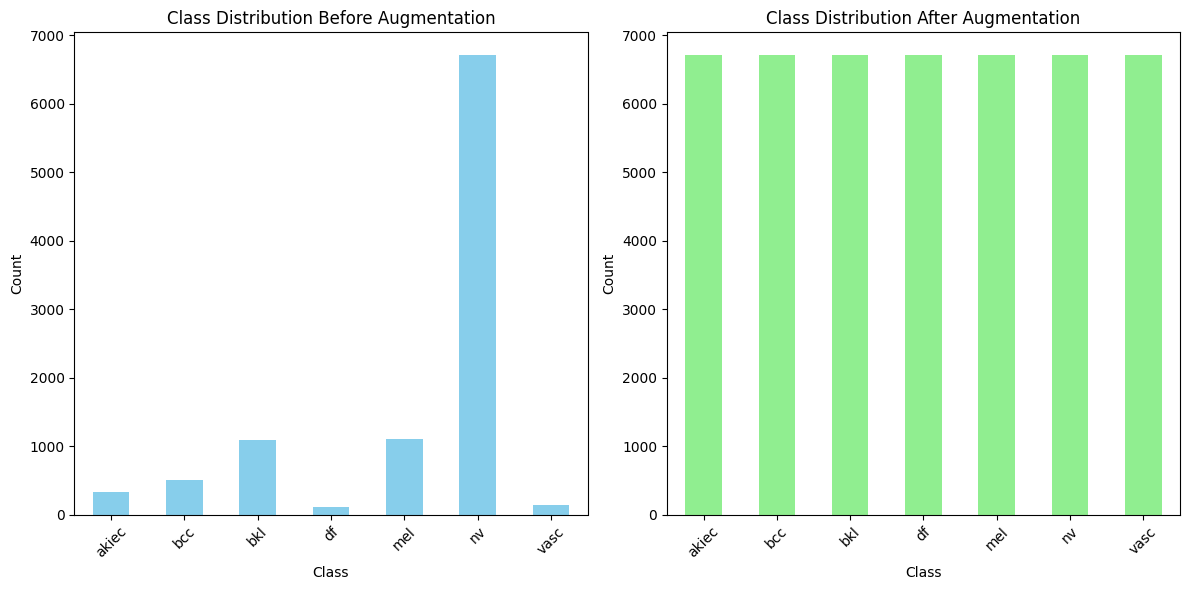

Balanced dataset saved to 'balanced_dataset.csv'


In [3]:

# Step 10: Convert augmented records to DataFrame and verify
augmented_df = pd.DataFrame(augmented_records)
print("\nAugmented DataFrame shape:", augmented_df.shape)
print(augmented_df.head())

# Step 11: Check file existence and adjust paths if needed
valid_paths = []
for idx, row in tqdm(augmented_df.iterrows(), desc="Verifying augmented files", total=len(augmented_df)):
    path = row['path']
    # Check if file exists with the expected name
    if os.path.exists(path):
        valid_paths.append(True)
    else:
        # Look for the file with a similar name pattern
        dir_path = os.path.dirname(path)
        filename = os.path.basename(path)
        prefix = filename.split('_')[0] + '_' + filename.split('_')[1]
        found = False
        for f in os.listdir(dir_path):
            if f.startswith(prefix):
                # Update the path to the actual filename
                augmented_df.at[idx, 'path'] = os.path.join(dir_path, f)
                valid_paths.append(True)
                found = True
                break
        if not found:
            valid_paths.append(False)

# Keep only valid paths
augmented_df = augmented_df[valid_paths]

# Step 12: Create final balanced dataset
final_df = pd.concat([df, augmented_df], ignore_index=True)

# Step 13: Verify the final class distribution
print("\nFinal dataset shape:", final_df.shape)
print("Final images per class after augmentation:")
final_counts = final_df['dx'].value_counts().sort_index()
print(final_counts)

# Step 14: Visualize the class distribution before and after augmentation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
final_counts.plot(kind='bar', color='lightgreen')
plt.title('Class Distribution After Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Save the final balanced DataFrame
final_df.to_csv('balanced_dataset.csv', index=False)
print("Balanced dataset saved to 'balanced_dataset.csv'")

In [9]:


# Basic imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For advanced augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

final_df = pd.read_csv("./balanced_dataset.csv")

In [6]:




class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['path']).convert("RGB"))
        label = row['label']
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, label


In [7]:
# Define image transformations first
IMAGE_SIZE = 224

# Albumentations transformations for training set (including augmentation)
train_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Albumentations transformations for validation and test sets (no augmentation)
val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Then create train/val/test splits
train_df, test_df = train_test_split(final_df, stratify=final_df['label'], test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = SkinCancerDataset(train_df, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, transform=val_transforms)
test_dataset = SkinCancerDataset(test_df, transform=val_transforms)

# Add DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

c:\Users\hasna\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [8]:
class CondensingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CondensingLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class AttentionCondenserBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionCondenserBlock, self).__init__()
        
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Depthwise spatial attention
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1x1(x)))
        attention = self.spatial_attn(out)
        return out * attention


class DCACNet(nn.Module):
    def __init__(self, num_classes):
        super(DCACNet, self).__init__()

        self.layer1 = CondensingLayer(3, 32)
        self.acb1 = AttentionCondenserBlock(32, 64)

        self.layer2 = CondensingLayer(64, 128)
        self.acb2 = AttentionCondenserBlock(128, 128)

        self.layer3 = CondensingLayer(128, 256)
        self.acb3 = AttentionCondenserBlock(256, 256)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.acb1(x)

        x = self.layer2(x)
        x = self.acb2(x)

        x = self.layer3(x)
        x = self.acb3(x)

        x = self.global_pool(x)
        x = self.classifier(x)
        return x


In [9]:
# Number of classes in HAM10000
num_classes = final_df['label'].nunique()

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DCACNet(num_classes=num_classes).to(device)

# Print model summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
   CondensingLayer-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           2,112
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8          [-1, 1, 112, 112]              65
           Sigmoid-9          [-1, 1, 112, 112]               0
AttentionCondenserBlock-10         [-1, 64, 112, 112]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
  CondensingLayer-14          [-1

In [10]:
import time

# Hyperparameters
EPOCHS = 25
LEARNING_RATE = 1e-3
PATIENCE = 5  # for early stopping

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


c:\Users\hasna\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Image shape: torch.Size([3, 224, 224]), Label: 4


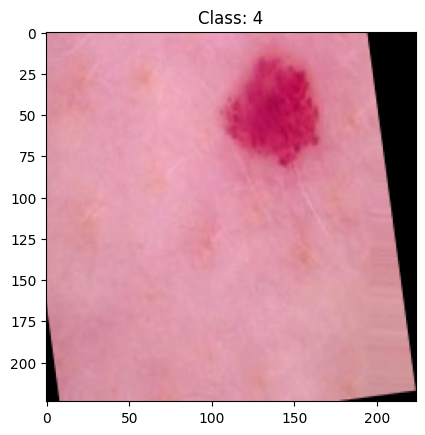

In [11]:
img, label = train_dataset[0]
print(f"Image shape: {img.shape}, Label: {label}")
plt.imshow(img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # de-normalize
plt.title(f"Class: {label}")
plt.show()


In [12]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [12]:
best_val_acc = 0.0
early_stop_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Starting the training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on validation data
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Update learning rate scheduler based on validation accuracy
    scheduler.step(val_acc)

    # Logging the loss and accuracy for training and validation
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Record the loss and accuracy
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        print("🔍 New best model found! Saving...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_dcac_model.pth")
        early_stop_counter = 0  # Reset early stop counter when a new best model is saved
    else:
        # Increment early stop counter if validation accuracy didn't improve
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break  # Stop training if early stopping is triggered



Epoch 1/25


100%|██████████| 939/939 [05:57<00:00,  2.62it/s]


Train Loss: 1.4611 | Train Acc: 0.4433
Val   Loss: 1.5240 | Val   Acc: 0.4642
🔍 New best model found! Saving...

Epoch 2/25


100%|██████████| 939/939 [04:26<00:00,  3.52it/s]


Train Loss: 1.2058 | Train Acc: 0.5526
Val   Loss: 1.0560 | Val   Acc: 0.6081
🔍 New best model found! Saving...

Epoch 3/25


100%|██████████| 939/939 [04:31<00:00,  3.46it/s]


Train Loss: 1.0645 | Train Acc: 0.6020
Val   Loss: 0.9130 | Val   Acc: 0.6558
🔍 New best model found! Saving...

Epoch 4/25


100%|██████████| 939/939 [04:32<00:00,  3.45it/s]


Train Loss: 0.9732 | Train Acc: 0.6346
Val   Loss: 0.8578 | Val   Acc: 0.6746
🔍 New best model found! Saving...

Epoch 5/25


100%|██████████| 939/939 [04:33<00:00,  3.43it/s]


Train Loss: 0.9076 | Train Acc: 0.6624
Val   Loss: 0.8140 | Val   Acc: 0.6937
🔍 New best model found! Saving...

Epoch 6/25


100%|██████████| 939/939 [04:33<00:00,  3.44it/s]


Train Loss: 0.8462 | Train Acc: 0.6843
Val   Loss: 0.7349 | Val   Acc: 0.7181
🔍 New best model found! Saving...

Epoch 7/25


100%|██████████| 939/939 [04:33<00:00,  3.43it/s]


Train Loss: 0.7934 | Train Acc: 0.7050
Val   Loss: 0.7079 | Val   Acc: 0.7340
🔍 New best model found! Saving...

Epoch 8/25


100%|██████████| 939/939 [04:33<00:00,  3.44it/s]


Train Loss: 0.7465 | Train Acc: 0.7204
Val   Loss: 0.7069 | Val   Acc: 0.7320

Epoch 9/25


100%|██████████| 939/939 [04:49<00:00,  3.24it/s]


Train Loss: 0.6949 | Train Acc: 0.7445
Val   Loss: 0.7419 | Val   Acc: 0.7333

Epoch 10/25


100%|██████████| 939/939 [04:53<00:00,  3.20it/s]


Train Loss: 0.6754 | Train Acc: 0.7481
Val   Loss: 0.6126 | Val   Acc: 0.7650
🔍 New best model found! Saving...

Epoch 11/25


100%|██████████| 939/939 [04:54<00:00,  3.19it/s]


Train Loss: 0.6400 | Train Acc: 0.7639
Val   Loss: 0.5934 | Val   Acc: 0.7800
🔍 New best model found! Saving...

Epoch 12/25


100%|██████████| 939/939 [04:52<00:00,  3.21it/s]


Train Loss: 0.6008 | Train Acc: 0.7783
Val   Loss: 0.5068 | Val   Acc: 0.8153
🔍 New best model found! Saving...

Epoch 13/25


100%|██████████| 939/939 [05:10<00:00,  3.03it/s]


Train Loss: 0.5760 | Train Acc: 0.7914
Val   Loss: 0.5719 | Val   Acc: 0.7980

Epoch 14/25


100%|██████████| 939/939 [06:35<00:00,  2.37it/s]


Train Loss: 0.5537 | Train Acc: 0.7964
Val   Loss: 0.7148 | Val   Acc: 0.7461

Epoch 15/25


100%|██████████| 939/939 [05:03<00:00,  3.09it/s]


Train Loss: 0.5246 | Train Acc: 0.8072
Val   Loss: 0.4651 | Val   Acc: 0.8253
🔍 New best model found! Saving...

Epoch 16/25


100%|██████████| 939/939 [05:32<00:00,  2.83it/s]


Train Loss: 0.5060 | Train Acc: 0.8150
Val   Loss: 0.4093 | Val   Acc: 0.8574
🔍 New best model found! Saving...

Epoch 17/25


100%|██████████| 939/939 [08:15<00:00,  1.89it/s]


Train Loss: 0.4861 | Train Acc: 0.8223
Val   Loss: 0.4394 | Val   Acc: 0.8357

Epoch 18/25


100%|██████████| 939/939 [05:13<00:00,  3.00it/s]


Train Loss: 0.4738 | Train Acc: 0.8268
Val   Loss: 0.4986 | Val   Acc: 0.8013

Epoch 19/25


100%|██████████| 939/939 [04:33<00:00,  3.43it/s]


Train Loss: 0.4519 | Train Acc: 0.8346
Val   Loss: 0.3565 | Val   Acc: 0.8750
🔍 New best model found! Saving...

Epoch 20/25


100%|██████████| 939/939 [04:31<00:00,  3.45it/s]


Train Loss: 0.4302 | Train Acc: 0.8452
Val   Loss: 0.6224 | Val   Acc: 0.7836

Epoch 21/25


100%|██████████| 939/939 [04:37<00:00,  3.38it/s]


Train Loss: 0.4256 | Train Acc: 0.8450
Val   Loss: 0.3913 | Val   Acc: 0.8539

Epoch 22/25


100%|██████████| 939/939 [04:33<00:00,  3.44it/s]


Train Loss: 0.4101 | Train Acc: 0.8509
Val   Loss: 0.3672 | Val   Acc: 0.8712

Epoch 23/25


100%|██████████| 939/939 [04:34<00:00,  3.42it/s]


Train Loss: 0.3389 | Train Acc: 0.8800
Val   Loss: 0.2716 | Val   Acc: 0.9015
🔍 New best model found! Saving...

Epoch 24/25


100%|██████████| 939/939 [04:35<00:00,  3.41it/s]


Train Loss: 0.3240 | Train Acc: 0.8846
Val   Loss: 0.2666 | Val   Acc: 0.9085
🔍 New best model found! Saving...

Epoch 25/25


100%|██████████| 939/939 [04:30<00:00,  3.47it/s]


Train Loss: 0.3154 | Train Acc: 0.8860
Val   Loss: 0.2993 | Val   Acc: 0.8948


In [13]:

# Import additional libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

# 1. Load the best model we saved during training
print("Loading best model...")
model.load_state_dict(torch.load("best_dcac_model.pth"))
model.eval()


Loading best model...


C:\Users\hasna\AppData\Local\Temp\ipykernel_5184\700400041.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dcac_model.pth"))


DCACNet(
  (layer1): CondensingLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (acb1): AttentionCondenserBlock(
    (conv1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (spatial_attn): Sequential(
      (0): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (1): Sigmoid()
    )
  )
  (layer2): CondensingLayer(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (acb2): AttentionCondenserBlock(
    (conv1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [14]:

# 2. Collect predictions and true labels from test set
all_preds = []
all_labels = []
all_probs = []  # For ROC curve

print("Generating predictions...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        
        _, preds = torch.max(outputs, 1)
        
        all_probs.extend(probabilities.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 3. Calculate and display accuracy
accuracy = np.mean(all_preds == all_labels)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")


Generating predictions...


Evaluating: 100%|██████████| 294/294 [02:31<00:00,  1.95it/s]


Test Accuracy: 90.80%


In [15]:

# 4. Generate and display classification report
# Create label map to convert indices back to human-readable class names
inv_lesion_type = {idx: label for label, idx in lesion_type_dict.items()}
class_names = [inv_lesion_type[i] for i in range(len(inv_lesion_type))]

print("\nClassification Report:")
report = classification_report(all_labels, all_preds, 
                               target_names=class_names,
                               digits=4)
print(report)



Classification Report:
              precision    recall  f1-score   support

         bkl     0.8659    0.7562    0.8073      1341
          nv     0.8293    0.9493    0.8853      1341
          df     0.9651    0.9896    0.9772      1341
         mel     0.8721    0.7778    0.8222      1341
        vasc     0.9978    0.9970    0.9974      1341
         bcc     0.8778    0.9799    0.9260      1341
       akiec     0.9544    0.9060    0.9296      1341

    accuracy                         0.9080      9387
   macro avg     0.9089    0.9080    0.9064      9387
weighted avg     0.9089    0.9080    0.9064      9387



<Figure size 1000x800 with 0 Axes>

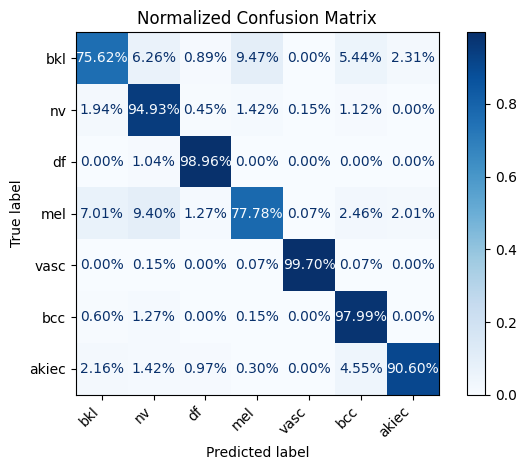

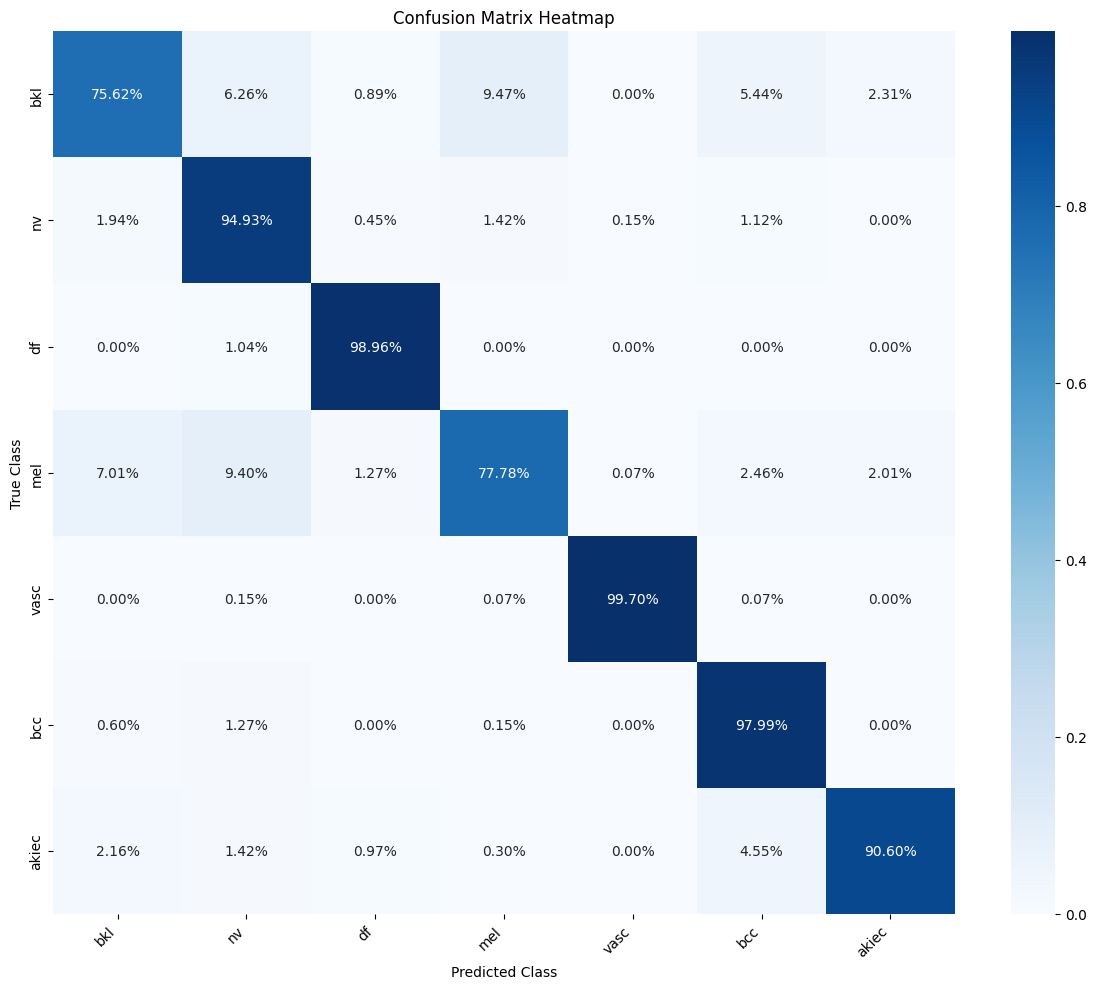

In [16]:

# 5. Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 6. Normalize confusion matrix (for better visualization)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 7. Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='.2%')
plt.xticks(rotation=45, ha="right")
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Create a more detailed heatmap with seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


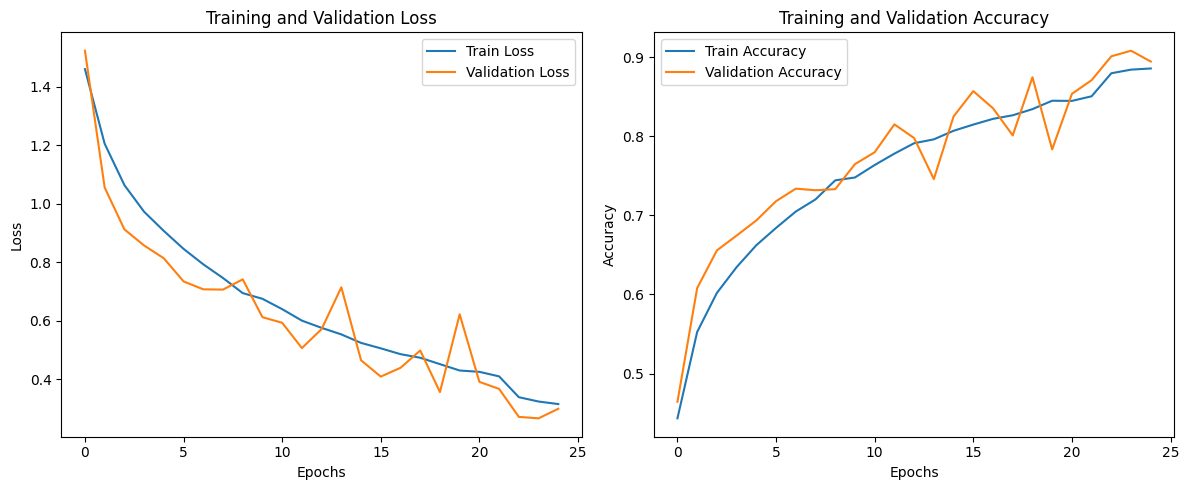

In [17]:

# 9. Plot training and validation loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()


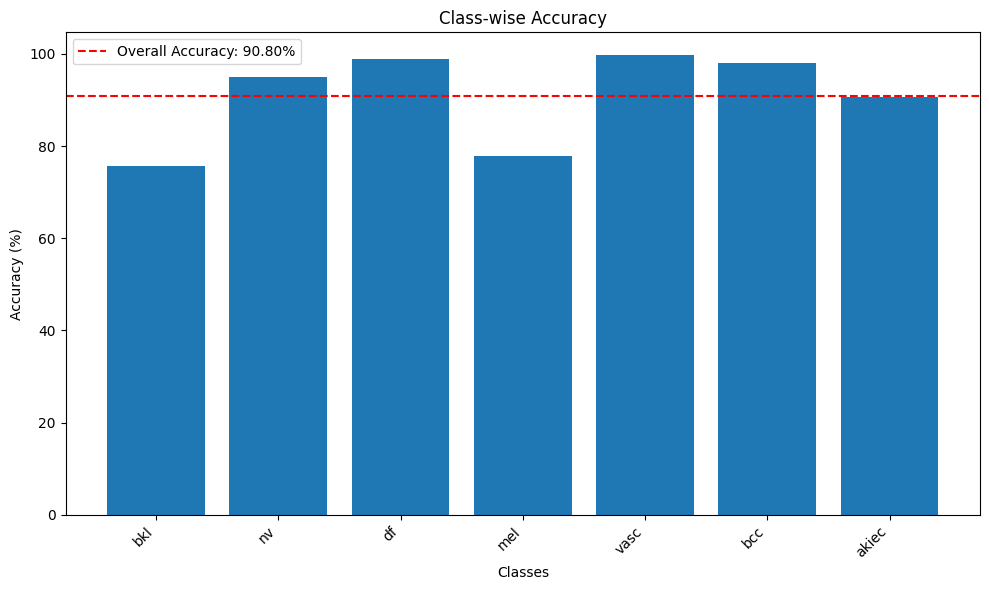

In [18]:

# 10. Class-wise accuracy (from confusion matrix)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy * 100)
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.xticks(rotation=45, ha="right")
plt.axhline(y=accuracy*100, color='r', linestyle='--', label=f'Overall Accuracy: {accuracy*100:.2f}%')
plt.legend()
plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=300)
plt.show()


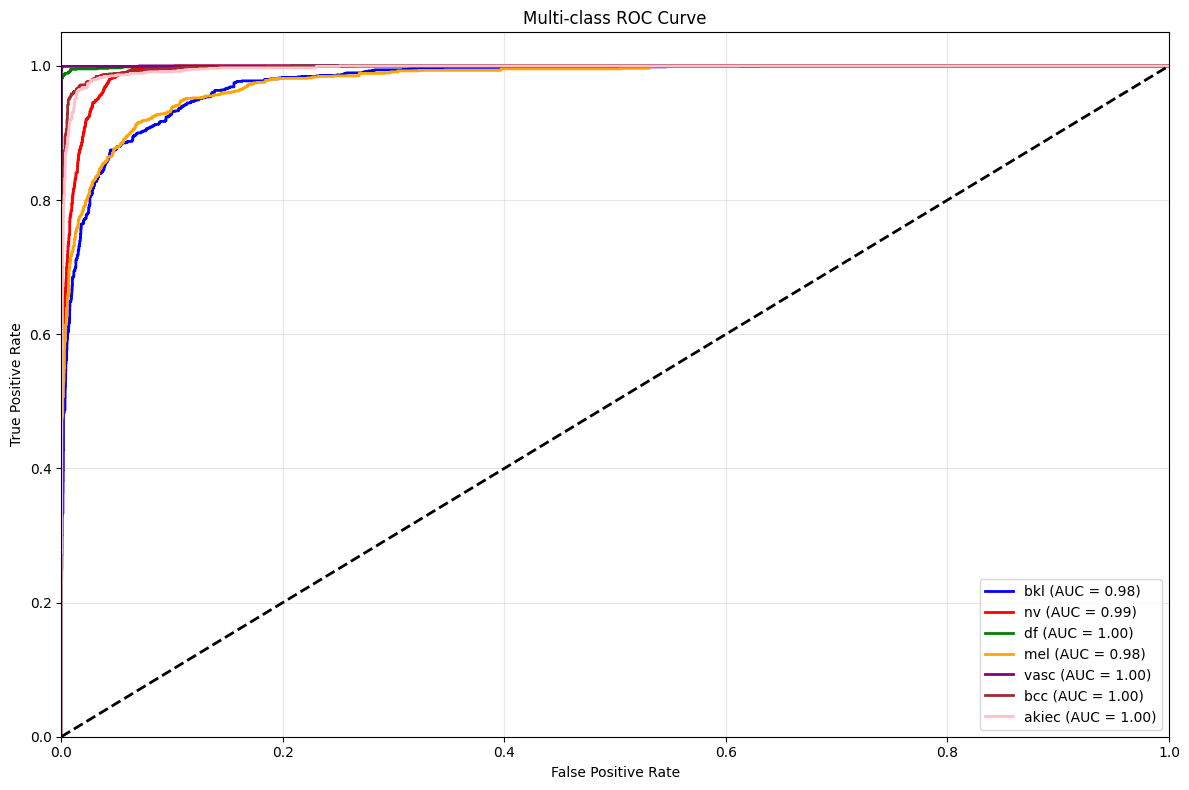

In [19]:

# 11. ROC Curves and AUC (for multi-class)
# Binarize labels for ROC curve calculation
n_classes = len(class_names)
y_test_bin = label_binarize(all_labels, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()


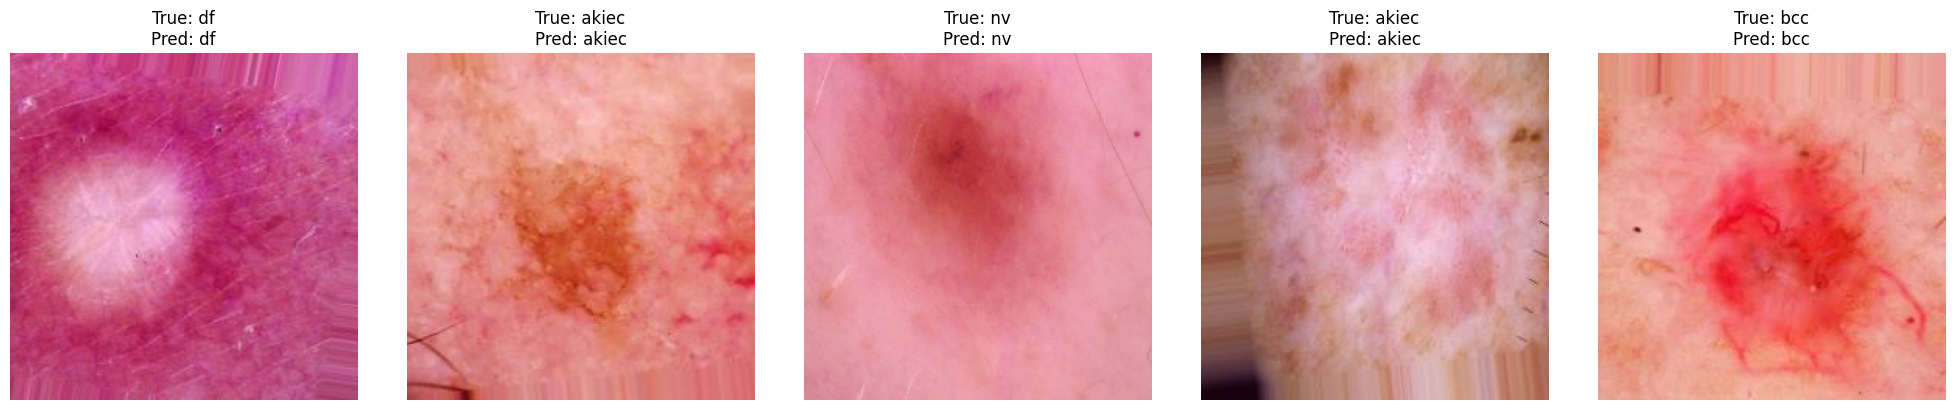

In [20]:
# 12. Show some correctly classified examples
correctly_classified_indices = np.where(all_preds == all_labels)[0]

if len(correctly_classified_indices) > 0:
    plt.figure(figsize=(20, 4))
    num_images = min(5, len(correctly_classified_indices))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        
        # Get the correctly classified sample from the dataset
        idx = correctly_classified_indices[i]
        
        img, true_label = test_dataset[idx % len(test_dataset)]
        pred_label = all_preds[idx]
        
        # Convert tensor to numpy and denormalize
        img = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        
        plt.imshow(img)
        plt.title(f"True: {inv_lesion_type[true_label]}\nPred: {inv_lesion_type[pred_label]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('correctly_classified_examples.png', dpi=300)
    plt.show()


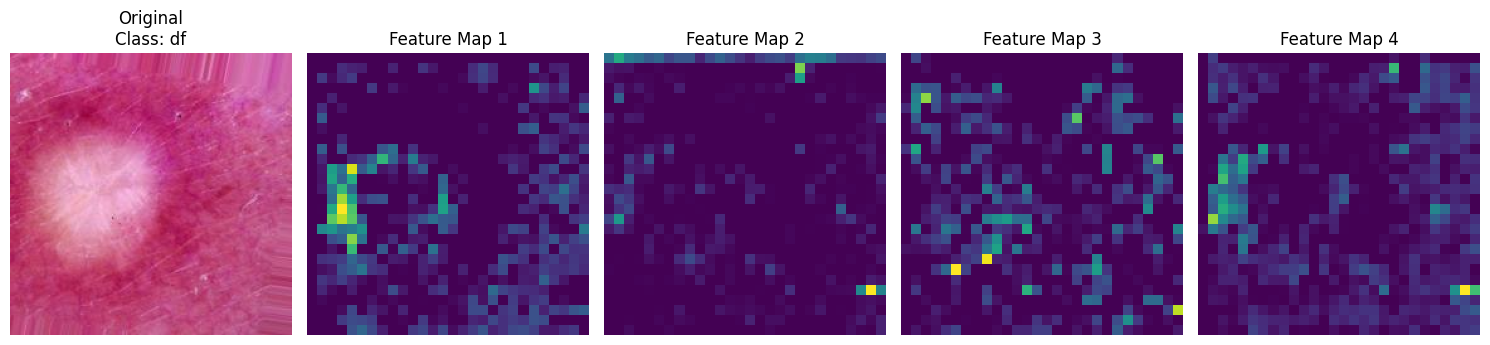

In [21]:

# 13. Feature activation visualization (for a sample image)
def visualize_layer_output(model, image_tensor, layer_name='acb3'):
    # Function to extract activations from a specific layer
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    if layer_name == 'acb1':
        handle = model.acb1.register_forward_hook(get_activation('acb1'))
    elif layer_name == 'acb2':
        handle = model.acb2.register_forward_hook(get_activation('acb2'))
    elif layer_name == 'acb3':
        handle = model.acb3.register_forward_hook(get_activation('acb3'))
    
    # Forward pass
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
    
    # Remove the hook
    handle.remove()
    
    # Get the activation
    activation = activations[layer_name].squeeze(0).cpu()
    
    return activation

# Get a sample image
sample_img, sample_label = test_dataset[0]
sample_img_tensor = sample_img.to(device)

# Visualize feature maps from the final attention layer
activation = visualize_layer_output(model, sample_img_tensor, 'acb3')

# Plot the original image and feature maps
plt.figure(figsize=(15, 8))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(sample_img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title(f"Original\nClass: {inv_lesion_type[sample_label]}")
plt.axis('off')

# Show first 4 feature maps
for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(activation[i].numpy(), cmap='viridis')
    plt.title(f"Feature Map {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('feature_maps.png', dpi=300)
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [11]:
class CondensingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CondensingLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class AttentionCondenserBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionCondenserBlock, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1x1(x)))
        attention = self.spatial_attn(out)
        return out * attention


class DCACNet(nn.Module):
    def __init__(self, num_classes):
        super(DCACNet, self).__init__()
        self.layer1 = CondensingLayer(3, 32)
        self.acb1 = AttentionCondenserBlock(32, 64)

        self.layer2 = CondensingLayer(64, 128)
        self.acb2 = AttentionCondenserBlock(128, 128)

        self.layer3 = CondensingLayer(128, 256)
        self.acb3 = AttentionCondenserBlock(256, 256)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.acb1(x)

        x = self.layer2(x)
        x = self.acb2(x)

        x = self.layer3(x)
        x = self.acb3(x)

        x = self.global_pool(x)
        x = self.classifier(x)
        return x


In [12]:
IMAGE_SIZE = 224

val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [13]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model and load weights
num_classes = 7  # Change according to your dataset
model = DCACNet(num_classes=num_classes)
model.load_state_dict(torch.load('./best_dcac_model.pth', map_location=device))
model = model.to(device)
model.eval()


C:\Users\hasna\AppData\Local\Temp\ipykernel_14324\1754344530.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_dcac_model.pth', ma

DCACNet(
  (layer1): CondensingLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (acb1): AttentionCondenserBlock(
    (conv1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (spatial_attn): Sequential(
      (0): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
      (1): Sigmoid()
    )
  )
  (layer2): CondensingLayer(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (acb2): AttentionCondenserBlock(
    (conv1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [14]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    augmented = val_transforms(image=img)
    img_tensor = augmented['image']

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor


In [15]:
def predict_single_image(img_path, model, class_names):
    img_tensor = preprocess_image(img_path)
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

    predicted_class = class_names[preds.item()]
    confidence = conf.item()

    return predicted_class, confidence


Image 1: Predicted Class: nv with 99.98% confidence
Image 2: Predicted Class: akiec with 45.47% confidence
Image 3: Predicted Class: mel with 75.67% confidence


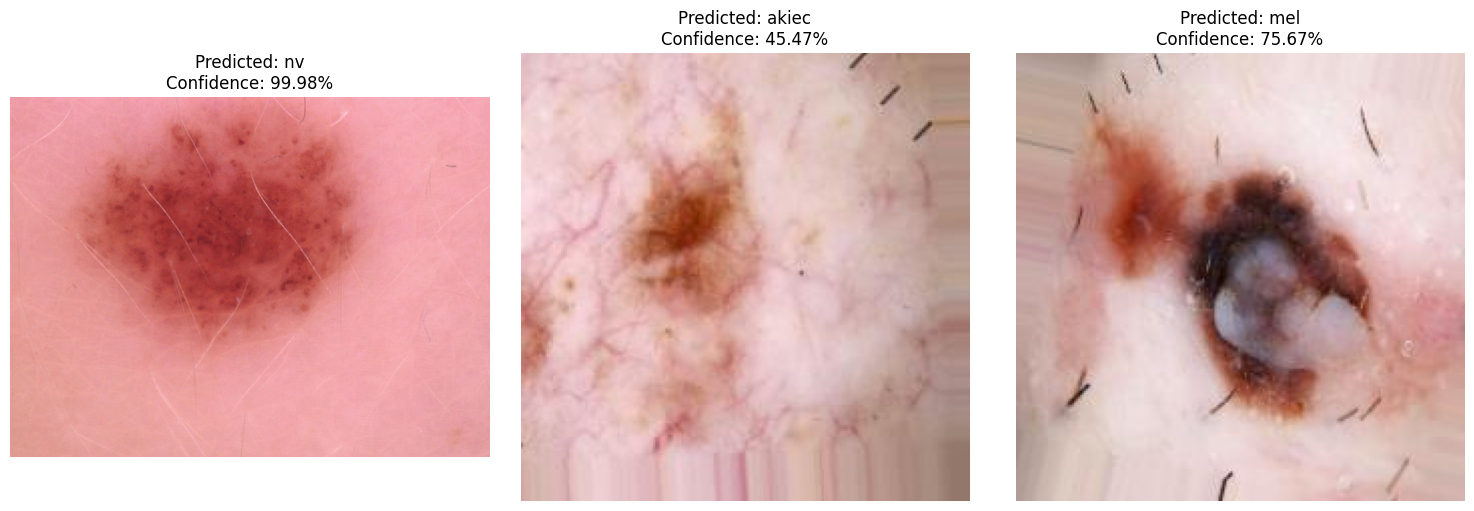

In [ ]:
# Load Metadata
metadata = pd.read_csv('./archive/HAM10000_metadata.csv')
label_list = metadata['dx'].unique()
label_map = {label: idx for idx, label in enumerate(label_list)}
idx_to_label = {idx: label for label, idx in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# Define image paths
image_path_1 = './archive/HAM10000_images_part_2/ISIC_0029326.jpg'
image_path_2 = './augmented_images/akiec_33_0_4955.jpg'
image_path_3 = './augmented_images/mel_3147_0_400.jpg'

# List of paths to predict
image_paths = [image_path_1, image_path_2, image_path_3]

# Predict for each image
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(image_paths):
    # Make prediction
    predicted_label, confidence = predict_single_image(image_path, model, class_names)
    
    # Display the image with prediction
    plt.subplot(1, 3, i+1)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence*100:.2f}%")
    plt.axis('off')
    
    # Print result
    print(f"Image {i+1}: Predicted Class: {predicted_label} with {confidence*100:.2f}% confidence")

plt.tight_layout()
plt.show()
